In [1]:
%matplotlib widget

import warnings
from typing import Optional, Sequence
import numpy as np
import os
import pandas as pd
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import datetime
import importlib
import math

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchmetrics.functional import pairwise_cosine_similarity
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

import lightly
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from avalanche.training.plugins import SupervisedPlugin
from avalanche.training.templates.supervised import SupervisedTemplate
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.models.dynamic_modules import MultiTaskModule
from avalanche.models import FeatureExtractorBackbone
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
    confusion_matrix_metrics,
)
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

import datasets.wrgbd
from datasets.coil100 import Coil100Dataset
from self_supervision.ssl import BarlowTwins, SimSiam
import clp.clp
from clp.clp import CLP


In [141]:
importlib.reload(datasets.wrgbd)
from datasets.wrgbd import WRGBD
from datasets.utils import SquarePad

root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
dataset_dir = '/home/ehajizad/datasets/rgbd-dataset'

model_name = "core50_simsiam_resnet9"

test_size = 0.2
train_size = 1 - test_size
subsampling_factor = 10
depth_mask = False
obj_level = False
seed = np.random.randint(1000)


# Dataset transforms
transform=transforms.Compose([
    SquarePad(global_max_wh=160),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# load dataset
train_ds = WRGBD(root_dir = dataset_dir, transform=transform, depth_mask = depth_mask, 
                     train_test_split='custom', subset='train',
                     obj_level=obj_level, subsampling_factor=subsampling_factor, seed=seed)
test_ds = WRGBD(root_dir = dataset_dir, transform=transform, depth_mask = depth_mask, 
                    train_test_split='custom', subset='test', 
                    obj_level=obj_level, subsampling_factor=subsampling_factor, seed=seed)

All target lists are created
All target lists are created


In [144]:
n_classes = len(np.unique(train_ds.targets))


nc_bm = nc_benchmark(train_ds, test_ds, 
                     n_experiences=n_classes, 
                     shuffle=False,task_labels=False)


device = "cuda" if torch.cuda.is_available() else "cpu"

vgg16 = torchvision.models.vgg16(weights='IMAGENET1K_V1')
# model = nn.Sequential(*list(vgg16.children())[:2], nn.Flatten(), *list(vgg16.children())[2][:2] )
model = vgg16.features
# model = model.to(device)


In [145]:
from torchvision import models
from torchinfo import summary
# conv_feat_ext = feat_ext
# conv_feat_ext = nn.Sequential(*list(feat_ext.children())[:-2],nn.AdaptiveAvgPool2d(1))

# conv_feat_ext = nn.Sequential(*list(feat_ext.children())[:2],*list(feat_ext.children())[:-2][2][:-6])
#, *list(feat_ext.children())[2][:2]
# conv_feat_ext = nn.Sequential(*list(feat_ext.children())[:2], nn.Flatten(), *list(feat_ext.children())[2][:2] )
summary(model, (1,3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 4, 4]            --
├─Conv2d: 1-1                            [1, 64, 128, 128]         1,792
├─ReLU: 1-2                              [1, 64, 128, 128]         --
├─Conv2d: 1-3                            [1, 64, 128, 128]         36,928
├─ReLU: 1-4                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-5                         [1, 64, 64, 64]           --
├─Conv2d: 1-6                            [1, 128, 64, 64]          73,856
├─ReLU: 1-7                              [1, 128, 64, 64]          --
├─Conv2d: 1-8                            [1, 128, 64, 64]          147,584
├─ReLU: 1-9                              [1, 128, 64, 64]          --
├─MaxPool2d: 1-10                        [1, 128, 32, 32]          --
├─Conv2d: 1-11                           [1, 256, 32, 32]          295,168
├─ReLU: 1-12                             [1, 256, 32, 32]       

In [146]:
# Generate embedding
ss_inds = list(range(0,len(train_ds.targets),100))
sub_dataset = torch.utils.data.Subset(train_ds, ss_inds)
feat_ext_dl = DataLoader(sub_dataset, batch_size=1, shuffle=True, num_workers=4)

embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        embeddings.append(emb)

embeddings = torch.cat(embeddings, 0)
# feature_size = 32768

In [147]:
from numpy import linalg 
def plot_cm(num_classes_learned, cm_results, obj_level=False, fig_size=4):
    plt.figure(figsize=(fig_size,fig_size))
    
    if obj_level:
        all_cls_names = np.array(train_ds.obj_names + ["Unknown"])
    else:
        all_cls_names = np.array(train_ds.cat_names + ["Unknown"])
    learned_cls_inds = nc_bm.classes_order[:num_classes_learned] + [n_classes]
    # +1's are for "Unknown" class
    num_classes_cm = num_classes_learned + 1
    
    # +1's are for "Unknown" class
    orig_cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"].numpy()
    cm = np.zeros((num_classes_cm,num_classes_cm))
    print(cm.shape)

    cls_inds = [(f,s) for f in learned_cls_inds for s in learned_cls_inds]
    cm_inds =  [(f,s) for f in range(num_classes_cm) for s in range(num_classes_cm)]
    
    cm[tuple(zip(*cm_inds))]=orig_cm[tuple(zip(*cls_inds))]
    
    cm = cm[:-1,:] # remove "Unknown" on the rows
    cm = cm / linalg.norm(cm, axis=1, ord=1).reshape(num_classes_learned,1)
    
    plt.imshow(cm)
    # excldue "Unknown" on the rows
    plt.xticks(np.arange(num_classes_cm), all_cls_names[learned_cls_inds], fontsize=6, rotation = 90) 
    plt.yticks(np.arange(num_classes_learned), all_cls_names[learned_cls_inds[:-1]], fontsize=6)
    plt.tight_layout()
    # plt.grid()
    # plt.show()

In [172]:
importlib.reload(clp.clp)
from clp.clp import CLP

alpha_start_list = [1]
sim_th_list = [0.40]
k_hit_list = [1.2]
k_miss_list = [1]
max_allowed_mis = [5]
sim_th_tau_crr_list = [20]
sim_th_tau_err_list = [20]

grid_search = []
multi_trial = []

n_loops = 2
n_cls_per_task = 16
n_cls_to_learn = 16

for k_hit in k_hit_list:
    for k_miss in k_miss_list:
        for sim_th_tau_crr in sim_th_tau_crr_list:
            for sim_th_tau_err in sim_th_tau_err_list:
        
                # log_dir = "logs/wrgbd/" +  "cosine_" + model_name + "_sim_th=" +str(sim_th) + \
                # "__" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

                # log_dir = "logs/coil_100_clean/" + "clp_test_size=0.9__sim_th=-6__max_miss=4_euclidean" 

                eval_plugin = EvaluationPlugin(
                        accuracy_metrics(experience=True, stream=True),
                        forgetting_metrics(experience=True, stream=True),
                        confusion_matrix_metrics(num_classes=n_classes+1, save_image=False, stream=True),
                        loggers=[],
                        benchmark=nc_bm
                )

                # CREATE THE STRATEGY INSTANCEi

                clvq = CLP(clvq_model=model,
                           n_protos=400,
                           bmu_metric="cosine",
                           criterion=None,
                           alpha_start=alpha_start_list[0],
                           sim_th=sim_th_list[0],
                           max_allowed_mistakes=max_allowed_mis[0],
                           k_hit=k_hit,
                           k_miss=k_miss,
                           sim_th_tau_crr=sim_th_tau_crr,
                           sim_th_tau_err=sim_th_tau_err,
                           verbose=1,
                           input_size=512*16,
                           eps=0.1,
                           num_classes=n_classes,
                           eval_mb_size=100,
                           train_mb_size=100,
                           train_epochs=1,
                           device=device,
                           evaluator=eval_plugin)

                clvq.init_prototypes_from_data(embeddings)

                # TRAINING LOOP

                n_alloc_protos_list = []
                n_alloc_protos_err_list = []
                cum_accs = []
                print("Starting experiment...")
                print ("k_hit="+str(k_hit) + ", k_miss="+str(k_miss) + ", sim_th_tau_crr=" + str(sim_th_tau_crr)+ ", sim_th_tau_err=" + str(sim_th_tau_err))
                for loop in range(1,n_loops+1):
                    for i, exp in enumerate(nc_bm.train_stream[:n_cls_to_learn]):

                        # fit SLDA model to batch (one sample at a time)
                        if i >= 16:
                            clvq.verbose=2
                        clvq.train(exp)
                        # clvq.memory_cleanup(0.35)
                        if (i+1)%n_cls_per_task == 0:
                            alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
                            n_alloc_protos = len(alloc_protos)
                            n_alloc_protos_err = clvq.n_alc_bc_miss

                            # evaluate model on test data
                            results = clvq.eval(nc_bm.test_stream[:i+1])
                            acc = results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
                            n_alloc_protos_list.append(n_alloc_protos)
                            n_alloc_protos_err_list.append(n_alloc_protos_err)
                            cum_accs.append(acc)
                            print("---------------------------------------------------------------------")
                            print("After learning ",str(i+1), " classes")
                            print("Total number of the allocated prototypes: ", str(n_alloc_protos))
                            print("The Number of error related prototypes allocation: ", str(n_alloc_protos_err))
                            print("Cumulative accuracy so far: ", str(acc))
                            # plot_cm(i+1, results, obj_level)
                            # plt.show()
                            print("---------------------------------------------------------------------")


                acc = results['Top1_Acc_Stream/eval_phase/test_stream/Task000']

                grid_search.append([k_hit, k_miss, sim_th_tau_crr, sim_th_tau_err, np.round(acc,3)])
                multi_trial.append([np.round(np.array(cum_accs),2), np.array(n_alloc_protos_list), np.array(n_alloc_protos_err_list)])
                # plot_cm(i+1, results, obj_level)
                # plt.show()


Starting experiment...
k_hit=1.2, k_miss=1, sim_th_tau_crr=20, sim_th_tau_err=20
Novel Label!
Novel Label!
Novel Instance!
0.0 -1
Novel Instance!
0.0 -1
Novel Label!
Novel Instance!
0.0 -1
Novel Label!
Novel Instance!
0.0 -1
Mistaken prototype: 0 40
sim_th & alpha: 0.5684571266174316 0.0048215873539447784
Mistaken prototype: 0 40
sim_th & alpha: 0.579099178314209 0.007232381030917168
Novel Label!
Novel Instance!
0.0 -1
Mistaken prototype: 1 24
sim_th & alpha: 0.4334944188594818 0.00704225804656744
Mistaken prototype: 1 24
sim_th & alpha: 0.4370150566101074 0.010563387535512447
Novel Instance!
0.0 -1
Novel Label!
Mistaken prototype: 3 107
sim_th & alpha: 0.6102132797241211 0.006896554492413998
Mistaken prototype: 3 107
sim_th & alpha: 0.6209908723831177 0.010344832204282284
Mistaken prototype: 3 107
sim_th & alpha: 0.6334094405174255 0.013793108984827995
Mistaken prototype: 3 107
sim_th & alpha: 0.6438080072402954 0.01724138669669628
Mistaken prototype: 3 107
sim_th & alpha: 0.653566062

(17, 17)


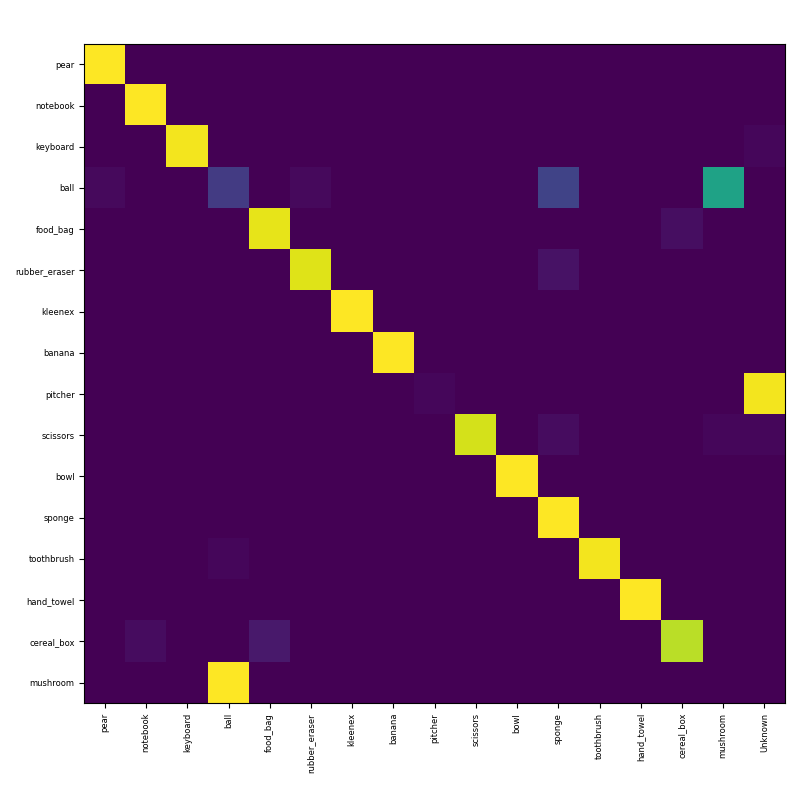

In [173]:
plot_cm(n_cls_to_learn, results, obj_level,8)
plt.show()

In [9]:
learned_cls_inds = nc_bm.classes_order[:n_cls_to_learn]
learned_cls_names = np.array(train_ds.cat_names)[learned_cls_inds]

for (i,j) in zip(learned_cls_inds, learned_cls_names):
    print(i,j)

10 bowl
21 dry_battery
34 peach
22 tomato
6 kleenex
25 soda_can
46 water_bottle
30 marker
39 food_jar
47 instant_noodles


In [46]:
grid_search = np.array(grid_search)

In [47]:
grid_search

array([[  1.   ,   0.5  ,  20.   ,  10.   ,   0.837],
       [  1.   ,   0.5  ,  20.   ,  20.   ,   0.82 ],
       [  1.   ,   0.5  ,  20.   ,  40.   ,   0.839],
       [  1.   ,   0.5  ,  50.   ,  10.   ,   0.825],
       [  1.   ,   0.5  ,  50.   ,  20.   ,   0.837],
       [  1.   ,   0.5  ,  50.   ,  40.   ,   0.811],
       [  1.   ,   0.5  , 100.   ,  10.   ,   0.839],
       [  1.   ,   0.5  , 100.   ,  20.   ,   0.845],
       [  1.   ,   0.5  , 100.   ,  40.   ,   0.837],
       [  1.   ,   0.5  , 150.   ,  10.   ,   0.834],
       [  1.   ,   0.5  , 150.   ,  20.   ,   0.81 ],
       [  1.   ,   0.5  , 150.   ,  40.   ,   0.818],
       [  1.   ,   1.   ,  20.   ,  10.   ,   0.821],
       [  1.   ,   1.   ,  20.   ,  20.   ,   0.804],
       [  1.   ,   1.   ,  20.   ,  40.   ,   0.809],
       [  1.   ,   1.   ,  50.   ,  10.   ,   0.801],
       [  1.   ,   1.   ,  50.   ,  20.   ,   0.784],
       [  1.   ,   1.   ,  50.   ,  40.   ,   0.768],
       [  1.   ,   1.   , 10

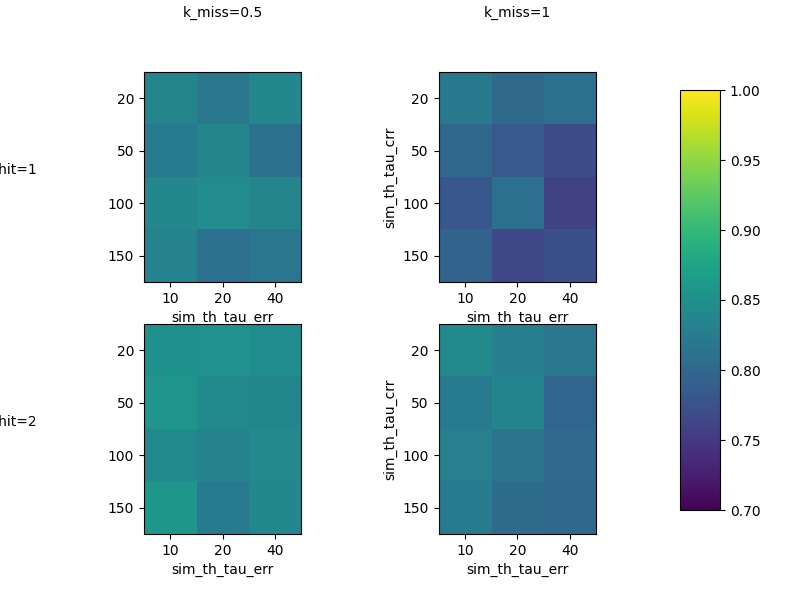

In [48]:
fig, axs = plt.subplots(len(k_hit_list),len(k_miss_list), figsize=(8,6))
axes = axs.ravel()
y_len = len(sim_th_tau_crr_list)
x_len = len(sim_th_tau_err_list)
grid_size = x_len * y_len
x = np.arange(x_len)
y = np.arange(y_len)
for i, ax in enumerate(axes):
    # im = ax.imshow(grid_search[:,4].reshape(y_len ,x_len), vmin=0.7, vmax=1)
    im = ax.imshow(grid_search[grid_size*i:grid_size*(i+1),4].reshape(y_len ,x_len), vmin=0.7, vmax=1)
    ax.set_xticks(x, sim_th_tau_err_list)
    ax.set_yticks(y, sim_th_tau_crr_list)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel("sim_th_tau_err", fontsize=10)
    ax.set_ylabel("sim_th_tau_crr", fontsize=10)

cols = ['k_miss={}'.format(col) for col in k_miss_list]
rows = ['k_hit={}'.format(row) for row in k_hit_list]

for ax, col in zip(axs[0,:], cols):
    ax.set_title(col, fontsize=10, pad=40)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, fontsize=10, labelpad=70)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=10)

# fig.tight_layout()
plt.show()

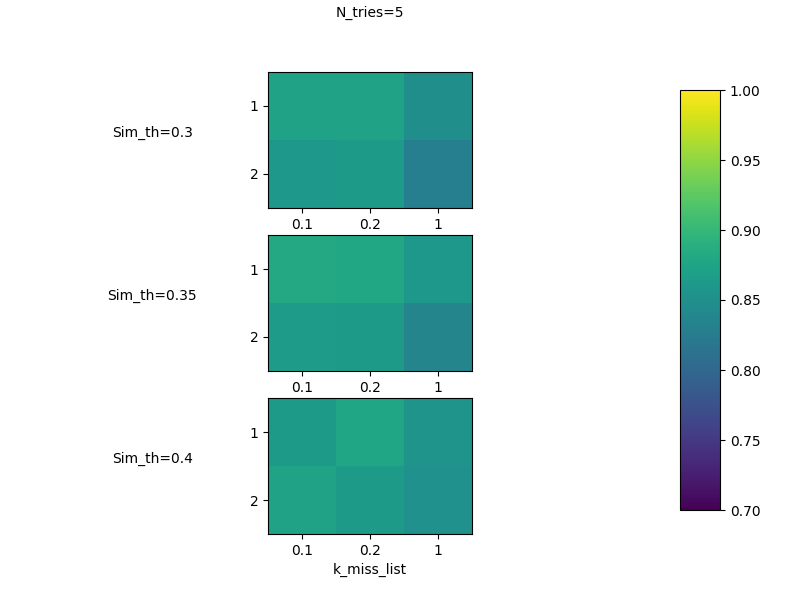

In [124]:
fig, axs = plt.subplots(len(sim_th_list),len(max_allowed_mis), figsize=(8,6))
axes = axs.ravel()
y_len = len(k_hit_list)
x_len = len(k_miss_list)
grid_size = x_len * y_len
x = np.arange(x_len)
y = np.arange(y_len)
for i, ax in enumerate(axes):
    # im = ax.imshow(grid_search[:,4].reshape(y_len ,x_len), vmin=0.7, vmax=1)
    im = ax.imshow(grid_search[grid_size*i:grid_size*(i+1),4].reshape(y_len ,x_len), vmin=0.7, vmax=1)
    ax.set_xticks(x, k_miss_list)
    ax.set_yticks(y, k_hit_list)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel("k_miss_list", fontsize=10)
    ax.set_ylabel("k_hit_list", fontsize=10)

cols = ['N_tries={}'.format(col) for col in max_allowed_mis]
rows = ['Sim_th={}'.format(row) for row in sim_th_list]

for ax, col in zip(axs, cols):
    ax.set_title(col, fontsize=10, pad=40)

for ax, row in zip(axs, rows):
    ax.set_ylabel(row, rotation=0, fontsize=10, labelpad=70)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=10)

# fig.tight_layout()
plt.show()

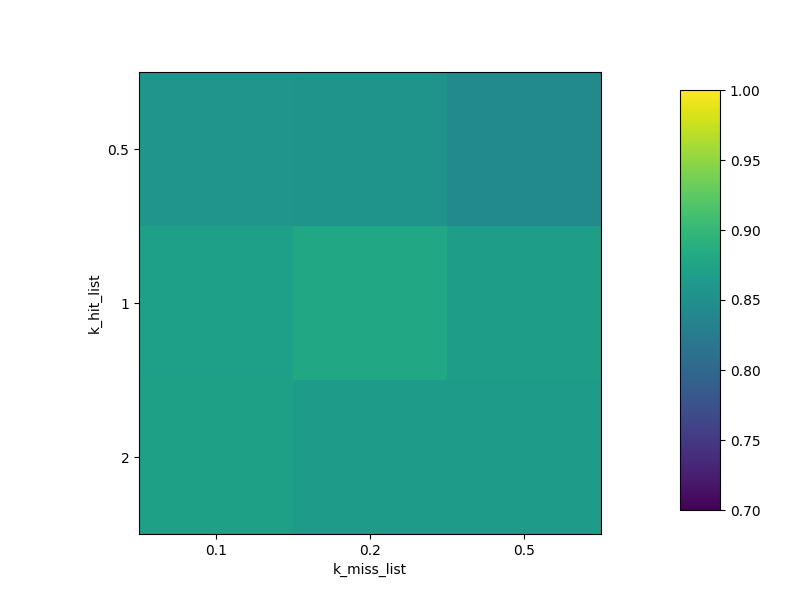

In [140]:
fig, axs = plt.subplots(len(sim_th_list),len(max_allowed_mis), figsize=(8,6))
# axes = axs.ravel()
axes=axs
y_len = len(k_hit_list)
x_len = len(k_miss_list)
grid_size = x_len * y_len
x = np.arange(x_len)
y = np.arange(y_len)
for i, ax in enumerate([axes]):
    im = ax.imshow(grid_search[:,4].reshape(y_len ,x_len), vmin=0.7, vmax=1)
    # im = ax.imshow(grid_search[grid_size*i:grid_size*(i+1),4].reshape(y_len ,x_len), vmin=0.7, vmax=1)
    ax.set_xticks(x, k_miss_list)
    ax.set_yticks(y, k_hit_list)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel("k_miss_list", fontsize=10)
    ax.set_ylabel("k_hit_list", fontsize=10)

cols = ['N_tries={}'.format(col) for col in max_allowed_mis]
rows = ['Sim_th={}'.format(row) for row in sim_th_list]

# for ax, col in zip(axs, cols):
#     ax.set_title(col, fontsize=10, pad=40)

# for ax, row in zip(axs, rows):
#     ax.set_ylabel(row, rotation=0, fontsize=10, labelpad=70)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=10)

# fig.tight_layout()
plt.show()

In [ ]:
all_cls_names = np.array(train_ds.obj_names)
learned_cls_inds = nc_bm.classes_order[:n_cls_to_learn]
for i in range(n_cls_to_learn):
    print(earned_cls_inds[i], all_cls_names[learned_cls_inds[i]])

207 pliers_4
164 food_cup_2
41 banana_1
71 toothbrush_1
124 tomato_4
26 food_bag_2
161 lightbulb_4
156 flashlight_2
265 food_box_4
0 pear_2
202 apple_4
89 cap_2
287 cell_phone_1
127 binder_3
296 potato_1
185 greens_3


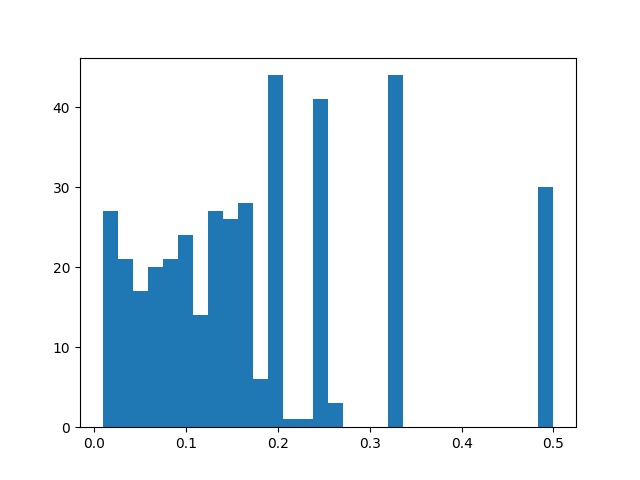

In [30]:
plt.figure()
plt.hist(np.array(clvq.alphas[clvq.alphas!=0.9].cpu()).flatten(),30)
plt.show()

In [10]:
np.set_printoptions(suppress=True)
results = np.array(multi_trial)

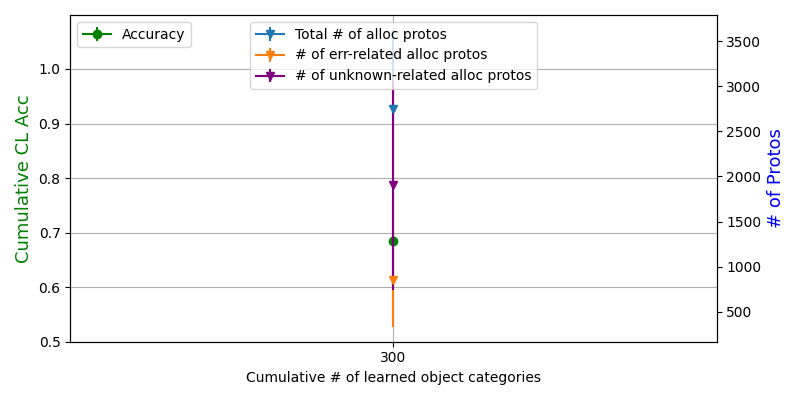

In [29]:

trail = 0
fig, ax1 = plt.subplots(figsize=(8,4))

ax2 = ax1.twinx()
x = np.arange(results.shape[-1])

acc_mean = np.mean(results[:,0,:],axis=0)
acc_std = np.std(results[:,0,:],axis=0)
ax1.errorbar(x, acc_mean, yerr=acc_std, fmt='-o', color='green')

n_unknown_protos = results[:,1,:] - results[:,2,:]

n_proto_mean = np.mean(results[:,1,:],axis=0)
n_proto_std = np.std(results[:,1,:],axis=0)
n_proto_err_mean = np.mean(results[:,2,:],axis=0)
n_proto_err_std = np.std(results[:,2,:],axis=0)
n_proto_uk_mean = np.mean(n_unknown_protos,axis=0)
n_proto_uk_std = np.std(n_unknown_protos,axis=0)
ax2.errorbar(x, n_proto_mean, fmt='-v', yerr=n_proto_std)
ax2.errorbar(x, n_proto_err_mean, fmt='-v', yerr=n_proto_err_std)
ax2.errorbar(x, n_proto_uk_mean, fmt='-v', yerr=n_proto_uk_std, c='purple')

ax2.legend(["Total # of alloc protos", "# of err-related alloc protos", "# of unknown-related alloc protos"], loc="upper center")
ax1.legend(["Accuracy"], loc="upper left")

ax1.set_ylabel('Cumulative CL Acc', color='g', fontsize=13)
ax2.set_ylabel('# of Protos', color='b', fontsize=13)

ax1.set_ylim([0.5,1.099])

ax1.set_xticks(x)
ax1.set_xticklabels(np.arange(n_cls_per_task,n_classes+n_cls_per_task,n_cls_per_task))
ax1.set_xlabel("Cumulative # of learned object categories")

ax1.grid()
plt.tight_layout()

In [63]:
np.arange(0,51,3).shape

(17,)

In [17]:
results['Top1_Acc_Stream/eval_phase/test_stream/Task000']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
np.sum(np.array(torch.Tensor.cpu(cm)),axis=1)

array([67, 81, 56, 80, 79, 79, 77, 73, 55, 56, 58, 61, 60, 79, 62, 75, 67,
       67, 66, 80, 62, 57, 62, 72, 71, 59, 77, 60, 58, 81, 68, 54, 72, 78,
       70, 63, 57, 82, 58, 79, 78, 64, 56, 80, 79, 80, 53, 80, 54, 62, 63])

In [9]:
# Generate training embeddings
feat_ext_dl = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=4)

train_embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        train_embeddings.append(emb)

train_embeddings = torch.cat(train_embeddings, 0)

In [10]:
# Generate test embeddings
feat_ext_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

test_embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        test_embeddings.append(emb)

test_embeddings = torch.cat(test_embeddings, 0)

In [80]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
len(alloc_protos)

1012

In [15]:
from sklearn.decomposition import PCA


# simSiam_con_emb = np.load('simSiam_con_emb.npz') 
# features = simSiam_con_emb['X'][:n_classes*72,:]
# all_targets = simSiam_con_emb['y'][:n_classes*72]
train_features = train_embeddings.cpu()
test_features = test_embeddings.cpu()
train_targets = train_ds.targets
test_targets = test_ds.targets
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
emb_and_protos = np.concatenate((train_features, test_features, alloc_protos), 0)

# pca = PCA(n_components=100)
# pca_result = pca.fit_transform(emb_and_protos)
# print('Cumulative explained variation: {}'.format(np.sum(pca.explained_variance_ratio_)))

In [82]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto', n_jobs=-1, n_iter_without_progress=100, verbose=2,
                 init='pca', perplexity=70, n_iter=2000, metric='cosine').fit_transform(emb_and_protos)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 21787 samples in 0.115s...
[t-SNE] Computed neighbors for 21787 samples in 22.770s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21787
[t-SNE] Computed conditional probabilities for sample 2000 / 21787
[t-SNE] Computed conditional probabilities for sample 3000 / 21787
[t-SNE] Computed conditional probabilities for sample 4000 / 21787
[t-SNE] Computed conditional probabilities for sample 5000 / 21787
[t-SNE] Computed conditional probabilities for sample 6000 / 21787
[t-SNE] Computed conditional probabilities for sample 7000 / 21787
[t-SNE] Computed conditional probabilities for sample 8000 / 21787
[t-SNE] Computed conditional probabilities for sample 9000 / 21787
[t-SNE] Computed conditional probabilities for sample 10000 / 21787
[t-SNE] Computed conditional probabilities for sample 11000 / 21787
[t-SNE] Computed conditional probabilities for sample 12000 / 21787
[t-SNE] Computed conditional probabilities for s

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 80.7794724, gradient norm = 0.0115782 (50 iterations in 7.432s)
[t-SNE] Iteration 100: error = 73.3526917, gradient norm = 0.0153770 (50 iterations in 7.296s)
[t-SNE] Iteration 150: error = 73.6177597, gradient norm = 0.0068525 (50 iterations in 7.429s)
[t-SNE] Iteration 200: error = 73.9691925, gradient norm = 0.0064783 (50 iterations in 7.356s)
[t-SNE] Iteration 250: error = 74.3625793, gradient norm = 0.0058293 (50 iterations in 7.496s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.362579
[t-SNE] Iteration 300: error = 2.4838774, gradient norm = 0.0008890 (50 iterations in 7.387s)
[t-SNE] Iteration 350: error = 1.8808410, gradient norm = 0.0004223 (50 iterations in 7.170s)
[t-SNE] Iteration 400: error = 1.5762248, gradient norm = 0.0002555 (50 iterations in 7.206s)
[t-SNE] Iteration 450: error = 1.3967624, gradient norm = 0.0001748 (50 iterations in 6.808s)
[t-SNE] Iteration 500: error = 1.2800708, gradient norm = 0.0001289 (50 

/tmp/ipykernel_433153/1910271960.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["y"] = cat_target_names


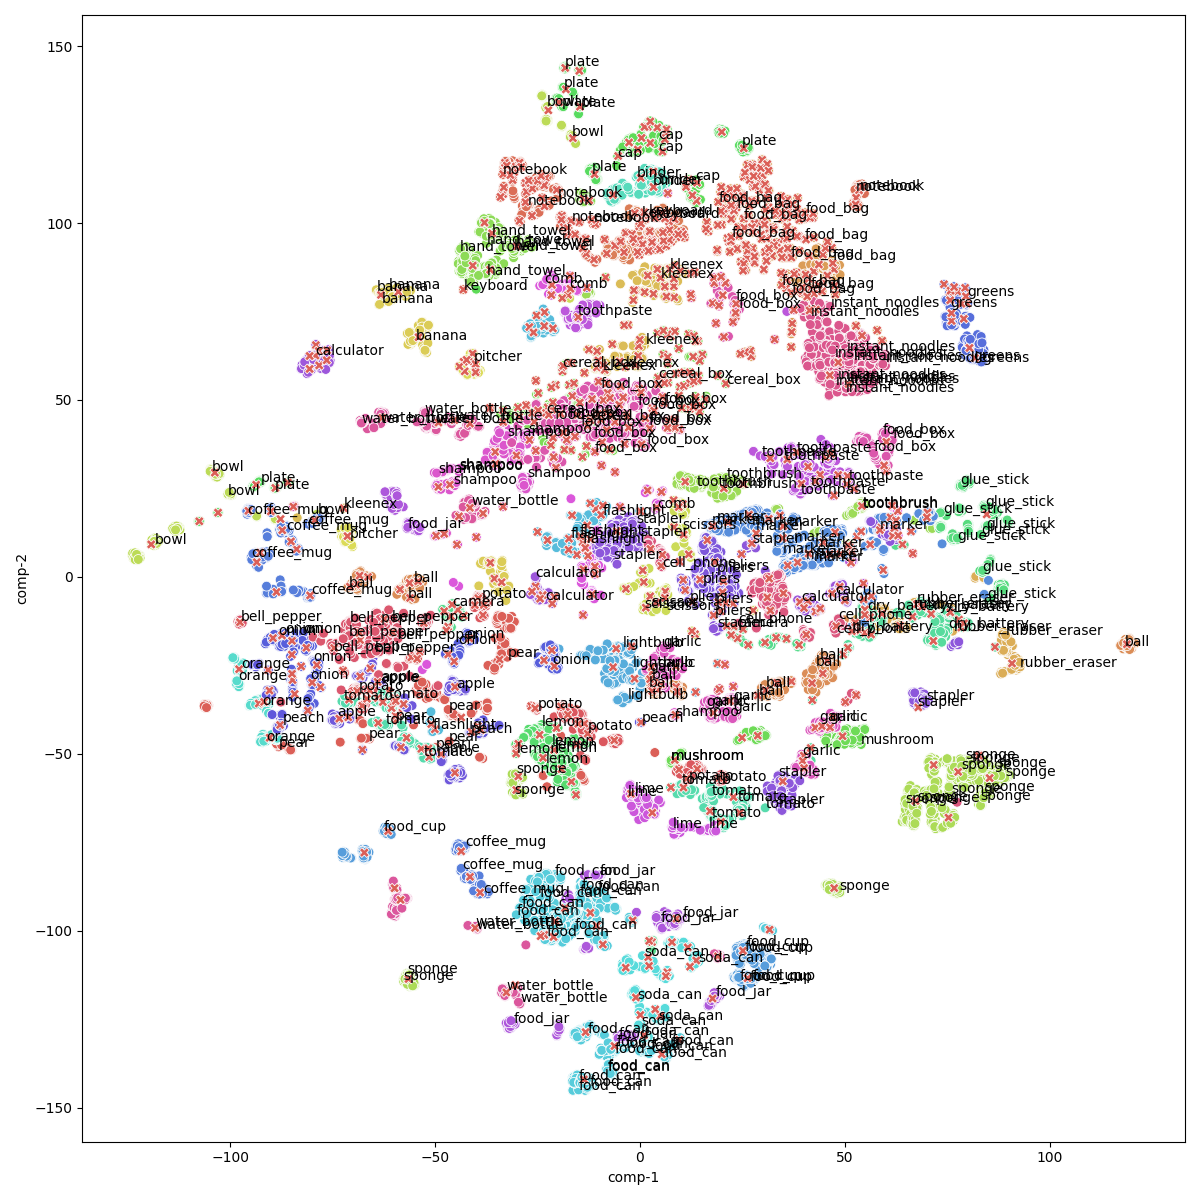

In [91]:
import seaborn as sns
y = np.concatenate((train_targets, test_targets, n_classes*np.ones((len(alloc_protos),))))
# y = all_targets.copy()
proto_label = y.copy()
proto_label[proto_label<n_classes] = 0
df = pd.DataFrame()
df["y"] = y.astype(int)
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]
plt.figure(figsize=(12,12))
# ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), style=proto_label, s=50,
#                     palette=sns.color_palette("hls", n_classes+1), legend=False,
#                     data=df)

train_df = df.iloc[:len(train_targets)]
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=train_df.y.tolist(), s=50,
                    palette=sns.color_palette("hls", n_classes), legend=False,
                    data=train_df)

test_df = df.iloc[len(train_targets):len(train_targets)+len(test_targets):]
# ax = sns.scatterplot(x="comp-1", y="comp-2", hue=test_df.y.tolist(), s=80,
#                     palette=sns.color_palette("hls", n_classes), legend=False,
#                     data=test_df)

all_data = [train_df, test_df]
# df = pd.concat(all_data)
# ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), s=80,
#                     palette=sns.color_palette("hls", n_classes), legend=False,
#                     data=df)

protos_df = df[df["y"]==n_classes]
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=protos_df.y.tolist(), marker="X", s=50,
                    palette=sns.color_palette("hls", 1), legend=False,
                    data=protos_df)


# ax.set(title="W-RGBD data T-SNE projection") 
cat_map_dict = dict( zip(range(len(train_ds.cat_names)), train_ds.cat_names) )
cat_target_names = [cat_map_dict[cat_ind] for cat_ind in train_df["y"]] 
train_df["y"] = cat_target_names
a = pd.concat({'x': train_df["comp-1"], 'y': train_df["comp-2"], 'label': train_df["y"]}, axis=1)
# a = a.sample(frac=0.02, replace=True, random_state=1)
a = a[::50]
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], point['label'], size=10)

plt.tight_layout()

In [88]:
obj_cat_id = train_ds.cat_names.index("calculator")
sponge_emb = train_embeddings[train_targets==obj_cat_id].cpu()


In [89]:
torch.sum(clvq.proto_labels == obj_cat_id)

tensor(24)

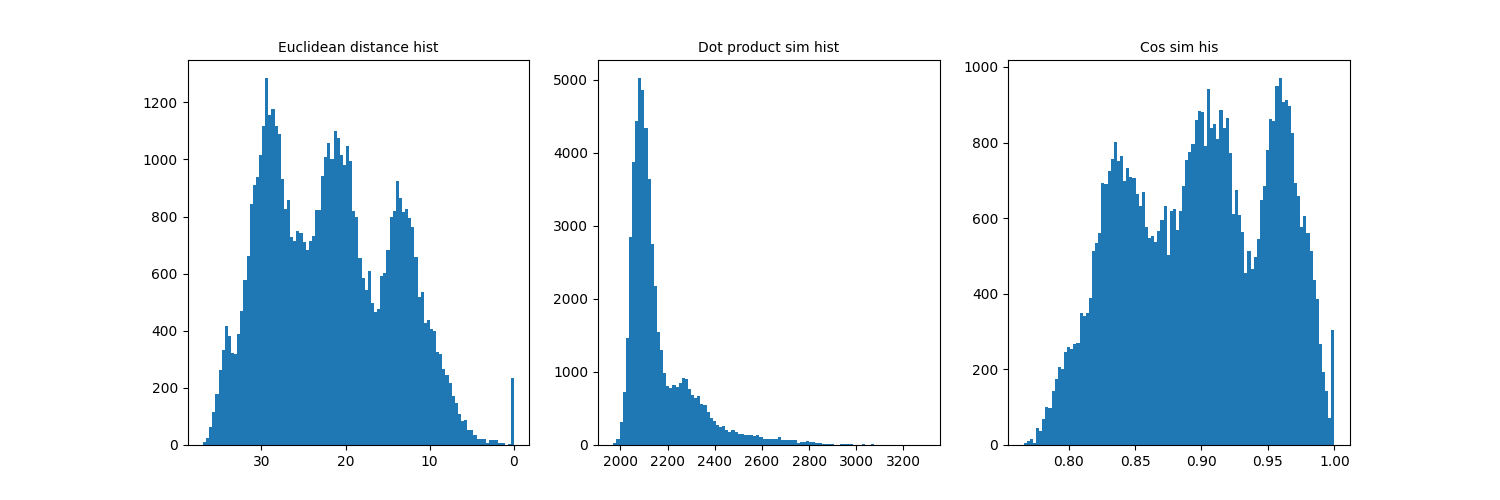

In [90]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

emb_sim = sponge_emb#[:1440]
sparsity_th = 0
# emb_sim[np.absolute(emb_sim)<sparsity_th]=0

# euclidian distance similarity for population coded data
distances = pdist(emb_sim, metric='euclidean')
dist_matrix = squareform(distances)

dp_sim = np.matmul(emb_sim,emb_sim.T)

cos_sim = cosine_similarity(emb_sim)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.hist(dist_matrix.flatten(),100)
ax2.hist(dp_sim.flatten(),100)
ax3.hist(cos_sim.flatten(),100)
ax1.set_title("Euclidean distance hist", fontsize=10)
ax2.set_title("Dot product sim hist", fontsize=10)
ax3.set_title("Cos sim his", fontsize=10)
ax1.set_xlim(ax1.get_xlim()[::-1])
plt.show()

20792

6830

In [113]:
250*3*300/5

45000.0

In [109]:
importlib.reload(datasets.wrgbd)
from datasets.wrgbd import WRGBD

from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn import svm



n_repeat = 1
# bmu_metrics = ["euclidean", "dot_product", "cosine"]
bmu_metrics = ["cosine"]
accs = np.zeros(shape=(len(bmu_metrics),n_repeat))
n_neighbors = 1

# Dataset transforms
subsampling_factor = 5
depth_mask = False

transform=transforms.Compose([
    SquarePad(global_max_wh=160),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# load dataset



for r in range(n_repeat):
    train_ds = WRGBD(root_dir = dataset_dir, transform=transform, depth_mask = depth_mask, train_test_split='custom', subset='train',
                 obj_level=True, subsampling_factor=subsampling_factor)
    test_ds = WRGBD(root_dir = dataset_dir, transform=transform, depth_mask = depth_mask, train_test_split='custom', subset='test', 
                    obj_level=True, subsampling_factor=subsampling_factor)

    # Generate training embeddings
    feat_ext_dl = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=4)

    train_embeddings = []
    with torch.no_grad():
        for batch in feat_ext_dl:
            image, label = batch 
            # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
            image, label = image.to(device), label.to(device)
            emb = model(image).flatten(start_dim=1)
            train_embeddings.append(emb)

    train_embeddings = torch.cat(train_embeddings, 0)

    # Generate test embeddings
    feat_ext_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

    test_embeddings = []
    with torch.no_grad():
        for batch in feat_ext_dl:
            image, label = batch 
            # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
            image, label = image.to(device), label.to(device)
            emb = model(image).flatten(start_dim=1)
            test_embeddings.append(emb)

    test_embeddings = torch.cat(test_embeddings, 0)
    
    train_features = train_embeddings.cpu()
    test_features = test_embeddings.cpu()
    train_targets = train_ds.targets
    test_targets = test_ds.targets

    X_train, X_test = np.array(train_features).copy(), np.array(test_features).copy()
    y_train, y_test = train_targets.copy(), test_targets.copy()
    
    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)
    
    
    clf = svm.LinearSVC(max_iter=10000)
    # clf = svm.LinearSVC(max_iter=10000)
    clf.fit(X_train, y_train)

    # y_pred_train=clf.predict(X_train)
    y_pred_test=clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc)
    
#     for bm, bmu_metric in enumerate(bmu_metrics):     
        
#         if bmu_metric != "dot_product":
#             knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=bmu_metric)
#             knn.fit(X_train, y_train)
#             y_pred_test=knn.predict(X_test)
            
#         else:
#             sim_X_train = np.matmul(X_train,X_train.T)
#             sim_X_test = np.matmul(X_test,X_train.T)

#             sim_X_train = np.max(sim_X_train) - sim_X_train
#             sim_X_test = np.max(sim_X_test) - sim_X_test
            
#             knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute",  metric="precomputed")
#             knn.fit(sim_X_train, y_train)

#             y_pred_test=knn.predict(sim_X_test)

#         # Model Accuracy: how often is the classifier correct?
#         acc = metrics.accuracy_score(y_test, y_pred_test)        
#         accs[bm, r] = acc

6 object are loaded
11 object are loaded
16 object are loaded
23 object are loaded
31 object are loaded
35 object are loaded
40 object are loaded
44 object are loaded
47 object are loaded
51 object are loaded
57 object are loaded
69 object are loaded
74 object are loaded
79 object are loaded
84 object are loaded
87 object are loaded
91 object are loaded
98 object are loaded
104 object are loaded
110 object are loaded
113 object are loaded
119 object are loaded
127 object are loaded
130 object are loaded
134 object are loaded
140 object are loaded
154 object are loaded
159 object are loaded
163 object are loaded
168 object are loaded
177 object are loaded
185 object are loaded
189 object are loaded
195 object are loaded
198 object are loaded
203 object are loaded
209 object are loaded
217 object are loaded
222 object are loaded
228 object are loaded
233 object are loaded
237 object are loaded
241 object are loaded
247 object are loaded
254 object are loaded
266 object are loaded
275 obj

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy: 0.8921675774134791


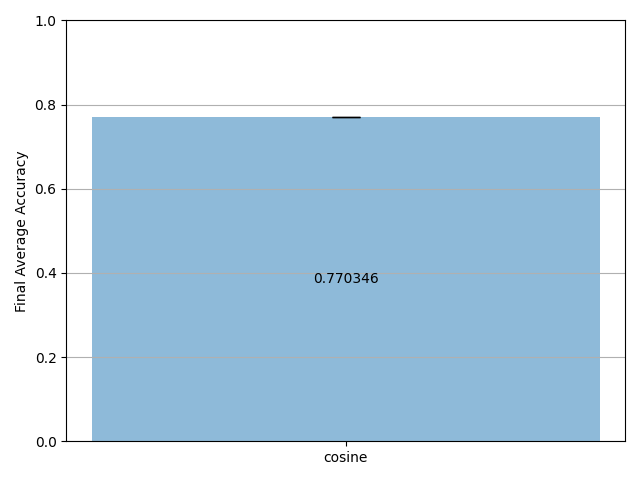

In [64]:
x_pos = np.arange(len(bmu_metrics))
CTEs = np.mean(accs, axis=1)
error = np.std(accs, axis=1)

# Build the plot
fig, ax = plt.subplots()
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Final Average Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(bmu_metrics)
ax.yaxis.grid(True)
ax.set_ylim([0,1])
ax.bar_label(bars, label_type='center')


# Save the figure and show
plt.tight_layout()
plt.show()
# print(CTEs)

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(4, 2, figsize=(25,45))
axes=axes.ravel()
df = pd.DataFrame()
df["y"] = y
perp_values = [5,10,15,20,30,40,50,60]
for i, p in enumerate(perp_values):
    X_tsne = TSNE(n_components=2, learning_rate='auto',metric='cosine',
                 init='pca', perplexity=p, n_iter=2000, n_iter_without_progress=100).fit_transform(emb_and_protos)
    df["comp-1"] = X_tsne[:,0]
    df["comp-2"] = X_tsne[:,1]
    axes[i].set_title("Perplexity="+str(p), fontsize=20)
    plt.sca(axes[i])
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", n_classes+1),legend=False,
                    data=df)

In [ ]:
torch.min(clvq.prototypes)

In [ ]:
for i, exp in enumerate(coil100_nc_bm.train_stream):
    print(exp.classes_in_this_experience)

In [ ]:
results=clvq.eval(coil100_nc_bm.test_stream)

In [ ]:
with open('clp_cosine.pkl', 'wb') as f:
    pickle.dump(results, f)
        
# with open('clp_cosine.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
plt.figure(figsize=(16,16))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)
results["Top1_Acc_Stream/eval_phase/test_stream/Task000"]

In [8]:
%load_ext tensorboard

In [9]:
%tensorboard --logdir 'logs/coil_100_clean/' --port 6009